# An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition  


Data : https://www.kaggle.com/datasets/ssarkar445/handwriting-recognitionocr  


# Import

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import zipfile

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras import backend as K
from tensorflow.keras import layers

In [2]:
# Data Directory
try:
  os.makedirs('/Text_Recognition/data')
except:
  pass

In [4]:
# 압축해제
zipfile.ZipFile('archive.zip').extractall('/Text_Recognition/data')

In [5]:
train_images_dir = os.path.join('data', 'train_v2/train')
val_images_dir = os.path.join('data', 'validation_v2/validation')
test_images_dir = os.path.join('data', 'test_v2/test')

In [6]:
train_csv = pd.read_csv(os.path.join('data/CSV', 'written_name_train.csv'))
val_csv = pd.read_csv(os.path.join('data/CSV', 'written_name_validation.csv'))
test_csv = pd.read_csv(os.path.join('data/CSV', 'written_name_test.csv'))

In [7]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


# Preprocessing

In [8]:
# 결측값 확인
print('Number of null values in train_csv: \n', train_csv.isna().sum(), '\n')
print('Number of null values in validation_csv: \n', val_csv.isna().sum(), '\n')
print('Number of null values in test_csv: \n', test_csv.isna().sum())

Number of null values in train_csv: 
 FILENAME      0
IDENTITY    565
dtype: int64 

Number of null values in validation_csv: 
 FILENAME     0
IDENTITY    78
dtype: int64 

Number of null values in test_csv: 
 FILENAME     0
IDENTITY    70
dtype: int64


In [9]:
# 결측값 제거
train_csv = train_csv.dropna()
val_csv = val_csv.dropna()
test_csv = test_csv.dropna()

Count of nreadable images: 102


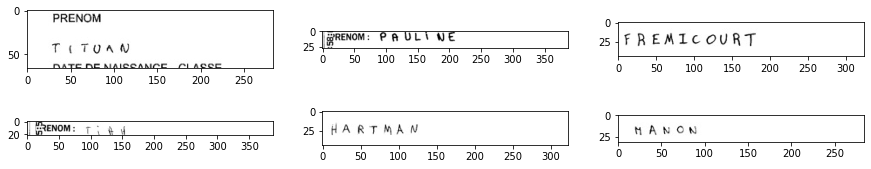

In [10]:
unreadable_indexes = train_csv[train_csv['IDENTITY']=='UNREADABLE'].index
print("Count of nreadable images: {}" .format(len(unreadable_indexes)))

plt.figure(figsize=(15,3))
offset = 10
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_name = train_csv.iloc[unreadable_indexes[i+offset], 0]
    image = cv2.imread(os.path.join(train_images_dir, image_name), cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, 'gray')

In [11]:
train_csv = train_csv[train_csv['IDENTITY']!='UNREADABLE']
val_csv = val_csv[val_csv['IDENTITY']!='UNREADABLE']
test_csv = test_csv[test_csv['IDENTITY']!='UNREADABLE']

In [12]:
train_csv['IDENTITY'] = train_csv['IDENTITY'].str.lower()
val_csv['IDENTITY'] = val_csv['IDENTITY'].str.lower()
test_csv['IDENTITY'] = test_csv['IDENTITY'].str.lower()



characters = set(char for label in train_csv['IDENTITY'].values for char in label)

print("Number of train samples found: ", len(train_csv.values))
print("Number of validation samples found: ", len(val_csv.values))
print("Number of test samples found: ", len(test_csv.values), '\n')
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of train samples found:  330294
Number of validation samples found:  41280
Number of test samples found:  41289 

Number of unique characters:  30
Characters present:  {'c', 'y', 'j', 'u', 'b', 'i', 'n', ' ', 'm', 'a', 'w', '`', 'f', 'x', 'l', 'h', 'r', 't', 'q', 'v', 'k', '-', 'o', 's', 'g', 'e', 'p', "'", 'z', 'd'}


In [13]:
# 토크나이저
max_length = max([len(label) for label in train_csv['IDENTITY'].values])
tokenizer = Tokenizer(num_words = max_length, char_level = True)
tokenizer.fit_on_texts(train_csv['IDENTITY'].values)
word_index = tokenizer.word_index

In [14]:
# Test
sample_sequence = tokenizer.texts_to_sequences(['sample text'])
sample_pad = pad_sequences(sample_sequence, maxlen = max_length, padding = 'post')
sample_text = tokenizer.sequences_to_texts(sample_sequence)
print("Sample sequence: ", sample_sequence[0])
print("Sample pad: ", sample_pad[0])
print("Sample text: ", sample_text[0])

Sample sequence:  [10, 2, 11, 18, 5, 1, 25, 8, 1, 24, 8]
Sample pad:  [10  2 11 18  5  1 25  8  1 24  8  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
Sample text:  s a m p l e   t e x t


In [15]:
img_width = 50
img_height = 200

images = train_csv['FILENAME'].values
labels = train_csv['IDENTITY'].values


def preprocess_single_sample(image_path, label, TEST = False):
    if TEST:
        img = cv2.imread(os.path.join(val_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(os.path.join(train_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
        
    img = cv2.resize(img,(img_height, img_width), interpolation = cv2.INTER_AREA)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) / 255
    
    label_sequence = tokenizer.texts_to_sequences([label])
    label = pad_sequences(label_sequence, maxlen = max_length, padding = 'post')[0]
    
    return img,label

In [16]:
train_length = 30000
val_length = 3000
test_length = 3000

indices = np.arange(len(train_csv))
np.random.shuffle(indices)

test_indices = np.arange(len(test_csv))
np.random.shuffle(test_indices)

In [17]:
print(indices)
print(test_indices)

[ 65500 172641 198599 ... 171869 179508 281849]
[27463  9101  4301 ... 27085 38041 38093]


# Train, Validation, Test

In [18]:
x_train = []
y_train = []
train_label_len = []
for i in tqdm(range(train_length)):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    train_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_train.append(img)
    y_train.append(label)
    
x_train = np.array(x_train)
y_train = np.array(y_train)
train_label_len = np.array(train_label_len)

100%|██████████| 30000/30000 [00:13<00:00, 2235.42it/s]


In [19]:
x_val = []
y_val = []
valid_label_len = []

for i in tqdm(range(train_length, train_length+val_length)):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    valid_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_val.append(img)
    y_val.append(label)

x_val = np.array(x_val)
y_val = np.array(y_val)
valid_label_len = np.array(valid_label_len)

100%|██████████| 3000/3000 [00:03<00:00, 758.13it/s]


In [20]:
x_test = []
y_test = []

for i in tqdm(range(test_length)):
    image_name = train_csv.iloc[test_indices[i], 0]
    label = train_csv.iloc[test_indices[i], 1]
    
    img, _ = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_test.append(img)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

100%|██████████| 3000/3000 [00:03<00:00, 990.48it/s]


In [21]:
print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape),'\n')

print('x_val shape: {}'.format(x_val.shape))
print('y_val shape: {}'.format(y_val.shape),'\n')

print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (30000, 200, 50, 1)
y_train shape: (30000, 34) 

x_val shape: (3000, 200, 50, 1)
y_val shape: (3000, 34) 

x_test shape: (3000, 200, 50, 1)
y_test shape: (3000,)


In [22]:
train_input_len = np.ones([train_length, 1]) * 48
valid_input_len = np.ones([val_length, 1]) * 48
valid_output = np.zeros([val_length])

# Model

![image](https://user-images.githubusercontent.com/94213374/214072183-e68d5a9f-9a0c-4b7d-bdb5-a541507502b9.png)


In [23]:
def ctc_loss(args):
    labels, y_pred, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [24]:
input_img = layers.Input(shape=(200, 50, 1), name="image")
labels = layers.Input(name="label", shape=(max_length,))
input_length = layers.Input(name='input_length', shape=(1,))
label_length = layers.Input(name='label_length', shape=(1,))

x = layers.Conv2D(
    64,(3, 3),activation="relu",kernel_initializer="he_normal",
    padding="same",name="Conv1",)(input_img)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)


x = layers.Conv2D(
    128,(3, 3),activation="relu",kernel_initializer="he_normal",
    padding="same",name="Conv2",)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)


x = layers.Conv2D(
    256,(3,3),activation='relu',kernel_initializer='he_normal',
    padding='same', name='Conv3')(x)
x = layers.Conv2D(
    256,(3,3),activation='relu',kernel_initializer='he_normal',
    padding='same', name='Conv4')(x)
x = layers.MaxPooling2D((1, 2), name="pool3")(x)


x = layers.Conv2D(
    512,(3,3),activation='relu',kernel_initializer='he_normal',
    padding='same', name='Conv5')(x)
x = layers.BatchNormalization()(x)


x = layers.Conv2D(
    512,(3,3),activation='relu',kernel_initializer='he_normal',
    padding='same', name='Conv6')(x)
x = layers.MaxPooling2D((1, 2), name="pool4")(x)


x = layers.Conv2D(
    512,(2,2),activation='relu',kernel_initializer='he_normal',
    padding='valid', name='Conv7')(x)


x = layers.Reshape(target_shape=(49,-1), name="reshape")(x)
x = layers.Dense(64, activation="relu", name="dense1")(x)
x = layers.Dropout(0.2)(x)


x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)

# # Output layer
y_pred = layers.Dense(
    len(characters) + 1, activation="softmax", name="output"
)(x)

loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, y_pred, input_length, label_length])

In [26]:
model = keras.models.Model(
    inputs=[input_img, labels, input_length, label_length], 
    outputs=loss_out,
    name="ocr_model_v2")

In [27]:
opt = keras.optimizers.Adam()

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)
model.summary()

Model: "ocr_model_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 64)  640         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 64)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 128  73856       ['pool1[0][0]']       

In [28]:
epochs = 50
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)

history = model.fit(
    x = (x_train, y_train, train_input_len, train_label_len),
    y = np.zeros([train_length]),
    validation_data=([x_val,y_val, valid_input_len, valid_label_len], np.zeros([val_length])),
    epochs=epochs,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/50
235/235 [==============================] - 111s 393ms/step - loss: 21.0207 - val_loss: 19.8806
Epoch 2/50
235/235 [==============================] - 83s 353ms/step - loss: 19.7338 - val_loss: 23.9108
Epoch 3/50
235/235 [==============================] - 84s 356ms/step - loss: 19.0312 - val_loss: 40.7169
Epoch 4/50
235/235 [==============================] - 83s 354ms/step - loss: 17.1773 - val_loss: 38.3263
Epoch 5/50
235/235 [==============================] - 83s 354ms/step - loss: 11.3726 - val_loss: 28.9488
Epoch 6/50
235/235 [==============================] - 83s 354ms/step - loss: 5.9181 - val_loss: 9.5029
Epoch 7/50
235/235 [==============================] - 83s 353ms/step - loss: 3.8698 - val_loss: 3.4453
Epoch 8/50
235/235 [==============================] - 84s 356ms/step - loss: 2.8578 - val_loss: 2.5301
Epoch 9/50
235/235 [==============================] - 83s 354ms/step - loss: 2.2843 - val_loss: 2.5152
Epoch 10/50
235/235 [==============================] - 83s 352

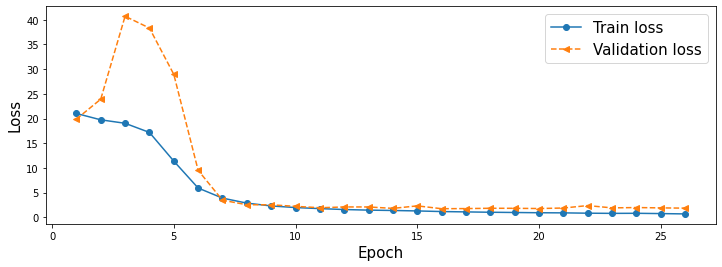

In [30]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))

plt.plot(x_arr, hist['loss'], '-o', label='Train loss')
plt.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.legend(fontsize=15)
plt.show()

# Predcition

In [31]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="output").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 64)       640       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 64)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 128)      73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 128)       0         
                                                                 
 Conv3 (Conv2D)              (None, 50, 12, 256)       295168    
                                                                 
 Conv4 (Conv2D)              (None, 50, 12, 256)       590080

In [32]:
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    for res in results:
        decoded = tokenizer.sequences_to_texts([res.numpy()])
        output_text.append(decoded)
    return output_text

In [33]:
preds = prediction_model.predict(x_test)
pred_texts = decode_predictions(preds)

94/94 [==============================] - 6s 40ms/step


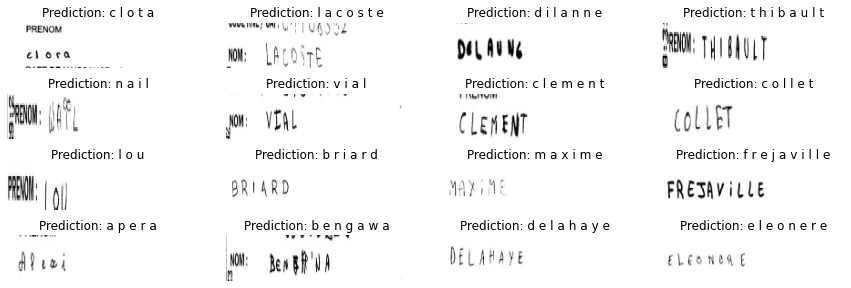

In [36]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = x_test[i]
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_texts[i][0]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()